In [1]:
# --- 0. Imports ---
import os, re, time, pickle
import numpy as np
import pandas as pd
import torch
import nltk
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
from xgboost import XGBClassifier

C:\Users\brysh\anaconda3\envs\gpu_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --- 1. Setup ---
nltk.download('stopwords')
stops = set(nltk.corpus.stopwords.words('english'))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\brysh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# --- 2. Data Loading & Cleaning ---
def load_and_prepare(path='shopee_reviews.csv'):
    df = pd.read_csv(path, encoding='latin-1', engine='python', on_bad_lines='skip')
    df.drop_duplicates(inplace=True)
    # Detect text column
    text_col = next(c for c in df.columns if df[c].dtype == 'object' and c.lower() != 'label')
    df['wc'] = df[text_col].str.count(r"\w+")
    df = df[df['wc'] >= 3]
    df['label'] = pd.to_numeric(df['label'], errors='coerce')
    df.dropna(subset=['label'], inplace=True)
    # Map ratings to binary: 4-5 => Genuine (1), 1-2 => Spam (0); drop 3s
    df = df[df['label'] != 3]
    df['sentiment'] = df['label'].astype(int).map(lambda x: 1 if x >= 4 else 0)
    return df[text_col].tolist(), df['sentiment']

X, y = load_and_prepare()
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)

In [4]:
# --- 3. Feature Augmentation ---
print('Step 3: Feature augmentation')

def extract_features(texts):
    feats = {'url_count': [], 'emoji_count': [], 'upper_ratio': [], 'repeat_word_ratio': []}
    for t in texts:
        s = str(t)
        feats['url_count'].append(len(re.findall(r'http\S+', s)))
        feats['emoji_count'].append(len(re.findall(r'[😀-🙏]', s)))
        words = s.split()
        up = sum(1 for w in words if w.isupper())
        feats['upper_ratio'].append(up/len(words) if words else 0)
        ws = [w.lower() for w in re.findall(r"\w+", s)]
        feats['repeat_word_ratio'].append((len(ws)-len(set(ws)))/len(ws) if ws else 0)
    return pd.DataFrame(feats)

num_train = extract_features(X_train)
num_val = extract_features(X_val)
num_test = extract_features(X_test)

Step 3: Feature augmentation


In [5]:
# --- 4. SBERT Embeddings ---
class SBERTTransformer(TransformerMixin):
    def __init__(self, model_name='all-MiniLM-L6-v2'):
        self.model = SentenceTransformer(model_name, device=device)
    def fit(self, X, y=None): return self
    def transform(self, X):
        cleaned = [
            ' '.join(w for w in re.findall(r"\w+", str(text).lower()) if w not in stops)
            for text in X
        ]
        embs, bs = [], 64
        for i in tqdm(range(0, len(cleaned), bs), desc='Embedding'):
            batch = cleaned[i:i+bs]
            embs.extend(self.model.encode(batch, show_progress_bar=False))
        return torch.from_numpy(np.array(embs))

emb_train = SBERTTransformer().transform(X_train)

Embedding: 100%|█████████████████████████████████████████████████████████████████| 13403/13403 [08:47<00:00, 25.43it/s]


In [6]:
# --- 4. SMOTE + XGBoost ---
print('Step 4: SMOTE + XGBoost')
sm = SMOTE(random_state=42)
start = time.time()
X_res, y_res = sm.fit_resample(emb_train.numpy(), y_train)
print(f'SMOTE done in {time.time()-start:.1f}s; counts={dict(zip(*np.unique(y_res,return_counts=True)))}')
# Compute class weight ratio
d = pd.Series(y_res).value_counts(); ratio = d[0]/d[1]
xgb = XGBClassifier(
    eval_metric='logloss', random_state=42,
    scale_pos_weight=ratio, n_estimators=2000,
    tree_method='hist', device='cuda', verbosity=1
)
start = time.time()
xgb.fit(X_res, y_res, verbose=True)
print(f'XGBoost trained in {time.time()-start:.1f}s')

Step 4: SMOTE + XGBoost
SMOTE done in 46.5s; counts={np.int64(0): np.int64(829894), np.int64(1): np.int64(829894)}
XGBoost trained in 296.1s


In [7]:
# --- 5. TF-IDF + LightGBM ---
print('Step 5: TF-IDF + LightGBM')
tfidf_lgb = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('lgb', lgb.LGBMClassifier(
        objective='binary', class_weight='balanced',
        n_estimators=1000, verbosity=-1
    ))
])
tfidf_lgb.fit(X_train, y_train)

Step 5: TF-IDF + LightGBM


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
                ('lgb',
                 LGBMClassifier(class_weight='balanced', n_estimators=1000,
                                objective='binary', verbosity=-1))])

In [8]:
# --- 6. Generate Stacking Features ---
print('Step 6: Generate stacking features')
# SBERT+XGB on validation
emb_val = SBERTTransformer().transform(X_val)
prob_xgb = xgb.predict_proba(emb_val.numpy())[:,1]
# TF-IDF+LGB on validation
tf = tfidf_lgb.named_steps['tfidf']; lm = tfidf_lgb.named_steps['lgb']
Xv_t = tf.transform(X_val); Xv_df = pd.DataFrame(Xv_t.toarray(), columns=tf.get_feature_names_out())
prob_lgb = lm.predict_proba(Xv_df)[:,1]
X_meta_train = np.vstack([prob_xgb, prob_lgb]).T
# repeat for test
emb_test = SBERTTransformer().transform(X_test)
px_t = xgb.predict_proba(emb_test.numpy())[:,1]
Xt_t = tf.transform(X_test); Xt_df = pd.DataFrame(Xt_t.toarray(), columns=tf.get_feature_names_out())
pl_t = lm.predict_proba(Xt_df)[:,1]
X_meta_test = np.vstack([px_t, pl_t]).T

Step 6: Generate stacking features


Embedding: 100%|███████████████████████████████████████████████████████████████████| 4468/4468 [02:33<00:00, 29.11it/s]
C:\Users\brysh\anaconda3\envs\gpu_env\lib\site-packages\xgboost\core.py:158: UserWarning: [14:46:09] WARNING: D:\bld\xgboost-split_1737531311373\work\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
Embedding: 100%|███████████████████████████████████████████████████████████████████| 4468/4468 [02:39<00:00, 28.03it/s]


In [9]:
# --- 7. Meta-Learner & Evaluation ---
print('Step 7: Meta-learner training & evaluation')
meta = LogisticRegression(class_weight='balanced', random_state=42)
meta.fit(X_meta_train, y_val)
# Validation probabilities for threshold tuning
prob_val = meta.predict_proba(X_meta_train)[:,1]
from sklearn.metrics import f1_score
thresholds = np.linspace(0,1,101)
f1_scores = [f1_score(y_val, (prob_val > t).astype(int)) for t in thresholds]
best_idx = np.argmax(f1_scores)
#best_thr = thresholds[best_idx]
best_thr = 0.05 # set threshold to 0.05
print(f'Optimal threshold on val (max F1): {best_thr:.2f} with F1 = {f1_scores[best_idx]:.3f}')
# Apply best threshold on test
prob_test = meta.predict_proba(X_meta_test)[:,1]
pred = (prob_test > best_thr).astype(int)
# Evaluation
print(classification_report(y_test, pred, target_names=['Spam','Genuine']))
print('Confusion Matrix:'); print(confusion_matrix(y_test, pred))
auc = roc_auc_score(y_test, prob_test); print(f'Meta AUC = {auc:.3f}')

Step 7: Meta-learner training & evaluation
Optimal threshold on val (max F1): 0.05 with F1 = 0.988
              precision    recall  f1-score   support

        Spam       0.59      0.71      0.64      9290
     Genuine       0.99      0.98      0.99    276632

    accuracy                           0.97    285922
   macro avg       0.79      0.84      0.81    285922
weighted avg       0.98      0.97      0.98    285922

Confusion Matrix:
[[  6554   2736]
 [  4548 272084]]
Meta AUC = 0.975


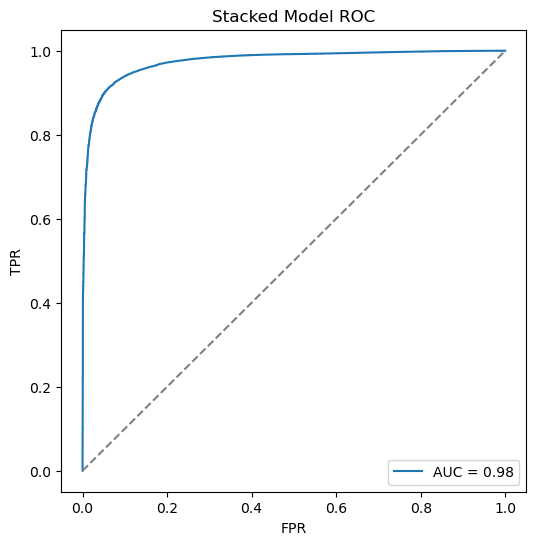

Saved stacked pipeline to shopee_stack_pipeline.pkl


In [10]:
# --- 8. ROC Curve & Save Pipeline ---
fpr, tpr, _ = roc_curve(y_test, prob_test)
plt.figure(figsize=(6,6)); plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}');
plt.plot([0,1],[0,1],'--', color='gray');
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('Stacked Model ROC'); plt.legend(); plt.show()

# Serialize sklearn pipeline
from sklearn.pipeline import Pipeline as SklearnPipeline
class StackWrapper(TransformerMixin):
    def __init__(self, embedder, xgbm, tf_lgbm, meta_clf):
        self.embedder, self.xgbm, self.tf_lgbm, self.meta_clf = embedder, xgbm, tf_lgbm, meta_clf
    def fit(self, X, y=None): return self
    def transform(self, X):
        e = self.embedder.transform(X).numpy()
        p1 = self.xgbm.predict_proba(e)[:,1]
        p2 = self.tf_lgbm.named_steps['lgb'].predict_proba(
            self.tf_lgbm.named_steps['tfidf'].transform(X).toarray() if hasattr(self.tf_lgbm.named_steps['tfidf'], 'transform') else X
        )[:,1]
        return np.vstack([p1, p2]).T

pipeline = SklearnPipeline([
    ('stack_feats', StackWrapper(SBERTTransformer(), xgb, tfidf_lgb, meta)),
    ('meta', meta)
])
with open('shopee_stack_pipeline.pkl', 'wb') as f:
    pickle.dump(pipeline, f)
print('Saved stacked pipeline to shopee_stack_pipeline.pkl')